# Preprocessing hydrography
Sometimes we might need to customize a pre-existing hydrography dataset in some way, for example by adding additional streams that weren't mapped or fixing errors in mapped streams. If we're working with a large area or with the High Resolution version of NHDPlus, we may also need to combine file sets from multiple areas, or prune intermittent headwater streams from the dataset. 

The preprocessing module of SFRmaker is intended to automate these tasks in a consistent, dependable way. Currently, the preprocessing module accepts NHDPlus version 2 data as input, and outputs either a culled and merged set of NHDPlus version 2 files (``cull_flowlines`` function) or a single shapefile with all of the information needed to build an SFR package (``preprocess_preprocess_nhdplus`` function).

As of SFRmaker 0.9.3, the preprocessing module is still a work in progress, and liable to change as improvements are made to streamline the workflow. This page is based on the ``preprocessing_demo.ipynb`` notebook in the ``examples/`` folder, and therefore reflects the current state of the code.

In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from sfrmaker.preprocessing import (
    clip_flowlines_to_polygon,
    cull_flowlines,
    preprocess_nhdplus
)

We start by supplying one or more paths to NHDPlus data (in the same structure as downloaded). Multiple drainage basins can be combined by included multiple paths in the list (for example, the Great Lakes and Upper Mississippi basins as shown here:

In [2]:
NHDPlus_paths_list = ['/NHDPlusGL/NHDPlus04/',
                      '/NHDPlusMS/NHDPlus07/']

### Merging and culling flowlines
The ``cull_flowlines()`` function culls NHDPlus version 2 data to a bounding box defined by an ``active_area`` coordinate tuple or polygon, and to flowlines with arbolate sums greater than specified thresholds. There are two arbolate sum thresholds:  

* ``asum_thresh``: all non perennial streams (with FCodes other than 46006) with arbolate sums less than this amount (in km) will be culled.
* ``intermittent_streams_asum_thresh``: streams coded as intermittent (FCode 46003) with arbolate sums less than this amount will be culled. This allows other features such as ditches or artifical paths to be culled more aggressively than intermittent streams.
    
Neither of the arbolate sum thresholds apply to streams classified as perennial, which are assumed to be important boundary conditions that should be included in the model. With the SFR package, streams are allowed to dry, in which case they have no effect on the groundwater solution (until there is water again). Therefore, the goal of culling of streams is mostly to achieve a stream network that is computationally managable and appropriate for the scale of the model, while retaining features that may affect groundwater flow.

``cull_flowlines()`` can also remove lines that are isolated from the stream network (``cull_isolated=True``) or are missing attribute information (``cull_invalid=True``). The output data are merged in a single set of NHDPlus version 2 files that are saved to ``outfolder``:

    elevslope.dbf
    PlusFlow.dbf
    PlusFlowlineVAA.dbf
    NHDFlowline.shp


The Tyler Forks example is contained in the Great Lakes basin, so we just need one path. We also need to specify a folder for writing the merged and culled files.

In [3]:
outfolder = Path('output')
outfolder.mkdir(exist_ok=True)

results = cull_flowlines(NHDPlus_paths=['../tylerforks/NHDPlus/'],
                         asum_thresh=3, intermittent_streams_asum_thresh=3,
                         cull_invalid=True, cull_isolated=False,
                         active_area='../tylerforks/active_area.shp',
                         outfolder=outfolder)

for basins:
../tylerforks/NHDPlus/

reading ../tylerforks/active_area.shp...
--> building dataframe... (may take a while for large shapefiles)

reading ../tylerforks/NHDPlus/NHDSnapshot/Hydrography/NHDFlowline.shp...
filtering on bounding box -90.59552642527598, 46.37324928457199, -90.45520721646749, 46.43603727904705...
--> building dataframe... (may take a while for large shapefiles)

reading ../tylerforks/NHDPlus/NHDPlusAttributes/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../tylerforks/NHDPlus/NHDPlusAttributes/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading ../tylerforks/NHDPlus/NHDPlusAttributes/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)
writing output/flowlines_gt3km.shp... Done
writing output/PlusFlowlineVAA_gt3km.dbf... Done
writing output/PlusFlow_gt3km.dbf... Done
writing output/elevslope_gt3km.dbf... Done


/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersion("3.0.0"):
/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersion("3.0.0"):


The output files are listed in a returned ``results`` dictionary, and are named based on ``asum_thresh``. This allows for easy experimentation with variuos arbolate sum thresholds, without a lot of extra file wrangling.

In [4]:
results

{'flowlines_file': 'output/flowlines_gt3km.shp',
 'pfvaa_file': 'output/PlusFlowlineVAA_gt3km.dbf',
 'pf_file': 'output/PlusFlow_gt3km.dbf',
 'elevslope_file': 'output/elevslope_gt3km.dbf'}

#### Plot the culled flowlines
We can use ``geopandas`` to quickly plot the results. As noted above, all perennial streams that intersect the active area bounding box are retained (blue lines). Within the active area, two intermittent streams with arbolate sums of less than 3km are culled (red lines).

<AxesSubplot: >

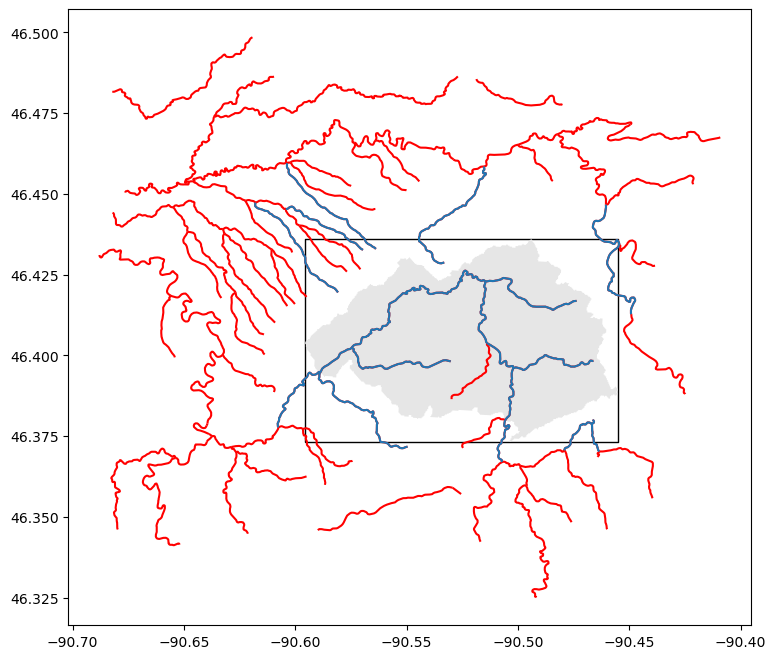

In [5]:
original_fl = gpd.read_file('../tylerforks/NHDPlus/NHDSnapshot/Hydrography/NHDFlowline.shp')
fig, ax = plt.subplots(figsize=(11.5, 8))
original_fl.plot(ax=ax, color='r')

culled_fl = gpd.read_file(results['flowlines_file'])
culled_fl.plot(ax=ax)

active_area = gpd.read_file('../tylerforks/active_area.shp')
active_area.plot(ax=ax, zorder=-1, fc='0.9')
active_area.envelope.plot(ax=ax, color='1.0', ec='k', zorder=-2)

### Preprocessing the flowlines
The ``preprocess_nhdplus()`` function creates a single shapefile with the information needed to build an SFR package (that can be input to [``sfrmaker.Lines.from_shapefile()``](https://aleaf.github.io/sfrmaker/latest/api/sfrmaker.lines.html#sfrmaker.lines.Lines.from_shapefile)). The set of unified NHDPlus files from ``cull_flowlines()`` can be input or, if no culling is needed and the project area falls within a single drainage basin, an original set of NHDPlus version 2 files can be used. 

The shapefile output from ``preprocess_nhdplus()`` can be thought of as a grid-independent representation of the SFR package. Further editing can be done on the shapefile either manually in a GIS environment, or automatically with the [``preprocessing.edit_flowlines()``](https://aleaf.github.io/sfrmaker/latest/api/sfrmaker.preprocessing.html#sfrmaker.preprocessing.edit_flowlines) function. Abstracting the key details of the SFR package to this shapefile allows for the SFR package to be easily regenerated if other apsects of the model (such as the grid) change.

To make a suitable SFR dataset, ``preprocess_nhdplus()`` does some additional processing that is described in more detail in the [code reference](https://aleaf.github.io/sfrmaker/latest/api/sfrmaker.preprocessing.html#sfrmaker.preprocessing.preprocess_nhdplus), including:  
* selecting a single downstream segment at each divergence, using zonal statistics computed on buffered areas (customizable with ``buffersize_meters``) around the lines. 
    * for instances where the automated proceedure selects the wrong distributary, or where routing information is absent in NHDPlus, connections can be established manually via a dictionary of ``FROMCOMID:TOCOMID`` pairs
* smoothed streambed elevations are also produced in the zonal statistics sampling; for large models with cell sizes of several hundred meters or more (in which zonal statistics may take a hour or longer to run), this may be preferable to sampling the elevations during the construction of the SFR package, which would greatly slow (re)building of the model.
* after the divergences are pruned to single downstream segments, arbolate sums are recomputed, and the lines can optionally be culled again with the ``asum_thresh`` argument here. This can be used to remove minor distributies that are only active during high water events, and therefore potentially not relevant to the groundwater model.
* the computed arbolate sums are also used to estimate channel widths, using the relationship $a\cdot arbolate\_sum ^b$ (Leaf, 2023; Feinstein et al, 2010). The $a$ and $b$ parameters in this relationship can be adjusted as needed to achieve the desired widths for a study area. A ``minimum_width`` can also be specified for headwater tributaries that may not be well represented by the above power-law relationship (and that may also have greater streambed conductance).

#### Additional processing options not shown below
* for large project areas, additional width information from the North American Width Dataset (NARWidth) can be incorporated via the ``narwidth_shapefile`` argument (see Leaf, 2023; Allen and Pavelsky, 2015 and the [code reference](https://aleaf.github.io/sfrmaker/latest/api/sfrmaker.preprocessing.html#sfrmaker.preprocessing.preprocess_nhdplus)
* field measurements of streambed elevation can be incorporated into the smoothed streambed elevations produced for each line, via the ``update_up_elevations`` and ``update_dn_elevations`` arguments.

In [6]:
preprocessed_flowlines = preprocess_nhdplus(
    flowlines_file=results['flowlines_file'],
    pfvaa_file=results['pfvaa_file'],
    pf_file=results['pf_file'],
    elevslope_file=results['elevslope_file'],
    demfile='../tylerforks/dem_26715.tif',
    dem_length_units='meters',
    buffersize_meters=50,
    asum_thresh= 3.,
    width_from_asum_a_param=0.0592,
    width_from_asum_b_param=0.5127,
    minimum_width=1.,
    known_connections={1814967: 1814897},
    output_length_units='meters',
    outfolder=outfolder,
    dest_crs=26915  # UTM zone 15 north   
)


reading output/PlusFlowlineVAA_gt3km.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading output/PlusFlow_gt3km.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading output/elevslope_gt3km.dbf...
--> building dataframe... (may take a while for large shapefiles)
writing output/flowlines_gt3km_buffers.shp... Done

Smoothing elevations...
finished in 0.00s
writing output/preprocessed_flowlines_gt3km.shp... Done


/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersion("3.0.0"):
/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersion("3.0.0"):
/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersion("3.0.0"):
/usr/share/miniconda/envs/sfrmaker_ci/lib/python3.9/site-packages/gisutils/shapefile.py:117: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(fiona.__gdal_version__) < LooseVersio

``preprocess_nhdplus()`` writes a shapefile of the preprocessed flowlines, and returns a GeoDataFrame representation that is described in detail in the [code reference](https://aleaf.github.io/sfrmaker/latest/api/sfrmaker.preprocessing.html#sfrmaker.preprocessing.preprocess_nhdplus).

In [7]:
preprocessed_flowlines.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,...,elevup,elevdn,elevupsmo,elevdnsmo,asum_calc,asum_diff,width1asum,width2asum,width1,width2
COMID,,,,,,,,,,,,,,,,,,,,,
1814983,1814983,1999-07-05,Medium,1580686,Tyler Forks,2.947,04010302000160,With Digitized,0,StreamRiver,...,343.306821,340.423057,343.306821,340.423057,133.052,0.0,7.558493,7.645791,7.558493,7.645791
1814907,1814907,1999-07-05,Medium,1580686,Tyler Forks,1.483,04010302000161,With Digitized,0,StreamRiver,...,344.879602,343.306821,344.879602,343.306821,125.007,0.0,7.359996,7.405168,7.359996,7.405168
1814869,1814869,1999-07-05,Medium,1580686,Tyler Forks,7.555,04010302000162,With Digitized,0,StreamRiver,...,353.596923,344.879602,353.596923,344.879602,119.314,0.0,6.991834,7.230301,6.991834,7.230301
1814859,1814859,1999-07-05,Medium,1580686,Tyler Forks,2.558,04010302000163,With Digitized,0,StreamRiver,...,367.339005,353.596923,367.339005,353.596923,107.771,0.0,6.778782,6.862785,6.778782,6.862785
1814897,1814897,1999-07-05,Medium,1580686,Tyler Forks,1.624,04010302000164,With Digitized,0,StreamRiver,...,389.698948,367.339005,389.698948,367.339005,102.417,0.0,6.631250,6.685816,6.631250,6.685816


<AxesSubplot: >

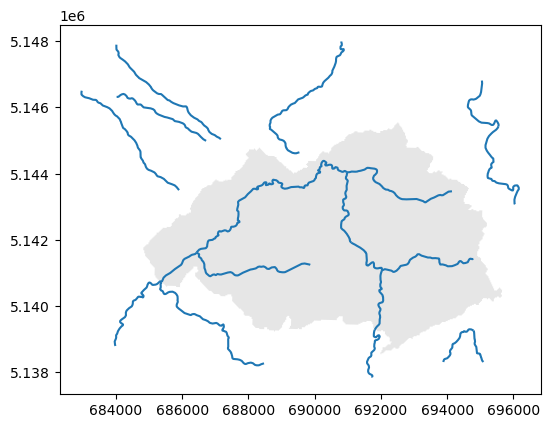

In [8]:
ax = preprocessed_flowlines.plot()
active_area.to_crs(26915).plot(ax=ax, zorder=-1, fc='0.9')

### Clipping the flowlines to a specific area
As a final step, we may want to clip the flowlines to an irregular area where SFR will be included in the model. For large project areas, this can reduce the file size and make the preprocessed lines easier to work with. This step may be best done last, so that the information in the surrounding flowlines (routing, elevations, etc) can be used in the preprocessing above. For large study areas with an overly detailed active area boundary (for example, one generated from a raster), specifying a simplification tolerance (``simplify_tol``) for the active area boundary can greatly speed up the clipping. All lines that intersect the simplified active area will be retained.

In [9]:
clipped_flowlines = clip_flowlines_to_polygon(
    preprocessed_flowlines, '../tylerforks/active_area.shp',
    simplify_tol=100)


reading ../tylerforks/active_area.shp...
--> building dataframe... (may take a while for large shapefiles)
starting lines: 19
remaining lines: 11


<AxesSubplot: >

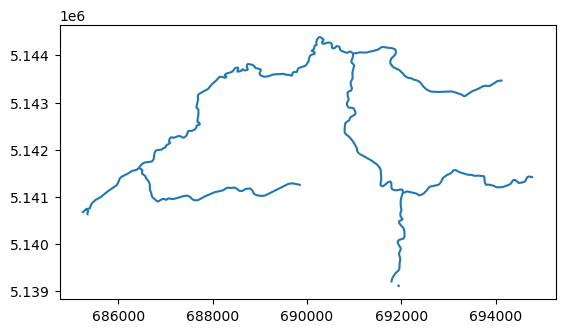

In [10]:
clipped_flowlines.plot()